This notebook aims at estimating the convergence rate of the fastPLN algorithm with respect to $p$. We will take a sample of size $n= 2000$. 

In [1]:
from scipy.linalg import toeplitz
from utils import build_block_Sigma, sample_PLN
import matplotlib.pyplot as plt

In [2]:
def show(model,name_doss , save = False,threshold = 0.01):
    '''
    function to show one model. It will plot the MSE of Sigma and beta according to the true parameters and 
    the log_likelihood in the y axis with the runtime in the x-axis.Will also plot the norm of the gradients and 
    the variance of the weights used for the importance sampling. 
    
    args : 
        'model' MC_PLNPCA object where you have called model.fit_IMPS()
        'name_doss' : str. the name of the file you want to save the graphic. 
        'save' : bool. If True, the graphic will be saved. If false, won't be saved. 
        
    returns : 
            None but displays the figure. It can also save the figure if save = True. 
    '''
    first = np.argmin(np.array(model.deltas)>threshold)
    first_time = model.running_times[first]
    fig,ax = plt.subplots(3,1,figsize = (15,15))

    #MSE of Sigma
    abscisse = model.running_times
    plt.subplots_adjust(hspace = 0.4)
    
    
    ax[0].plot(abscisse, model.MSE_Sigma_list)
    ax[0].set_title(r'MSE $(\Sigma- \hat \Sigma)$')
    ax[0].set_xlabel('Seconds')
    ax[0].set_ylim(ymin= 1e-4)
    ax[0].set_ylabel('(a)')
    ax[0].axvline(first_time, c = 'red', label = 'threshold')
    ax[0].set_yscale('log')
    
    #MSE of beta. 
    ax[1].plot(abscisse, model.MSE_beta_list)
    ax[1].set_title(r'MSE $(\beta - \hat \beta)$') 
    ax[1].set_yscale('log')
    ax[1].set_ylim(ymin= 1e-4)
    ax[1].set_ylabel('(b)')
    ax[1].axvline(first_time, c = 'red', label = 'threshold')
    ax[1].legend()
    
    
    # plot the L1 norm of the gradients. 
    ax[2].plot(abscisse, model.deltas, label = 'norm grad loglike C')
    ax[2].set_title('criteria')
    ax[2].legend()
    
    ax[2].axvline(first_time, c = 'red', label = 'threshold')
    ax[2].axhline(threshold, c = 'red', label = 'threshold')
    '''
    
    #here we plot the variance for the 3 integrals. We set a threshold from which we consider that the integral 
    # is misestimate if the variance of the weights is above. 
    threshold = 0.9
    # integral for beta 
    ax[4].scatter( np.linspace(0,abscisse[-1], model.var_weights['beta'].shape[0]), model.var_weights['beta'],s = 1, label = 'variance of the weights for beta', c = 'black')
    percentage_bad_beta = np.sum(model.var_weights['beta']>threshold)/(model.var_weights['beta'].shape[0])
    ax[4].axhline(model.acc, c = 'red', label = 'reference')
    ax[4].set_title('Variance beta, pourcentage of bad approximations : '+ str(np.round(percentage_bad_beta,3)))
    ax[4].set_yscale('log')
    ax[4].legend()
    '''
    if save : 
        plt.savefig(name_doss)
    plt.show()

In [3]:
import math
import time 

import numpy as np
import torch
import seaborn as sns
import scipy.linalg as SLA 
torch.set_default_dtype(torch.float64)

#get the device
if torch.cuda.is_available(): 
    device = torch.device('cuda') 
else : 
    device = torch.device('cpu')
print('device : ', device)

def grad_M(Y, O, covariates ,M ,S ,Sigma ,beta):
    grad = Y - torch.exp(O+M+torch.multiply(S,S)/2)-torch.mm(M-torch.mm(covariates,beta), torch.inverse(Sigma))
    return grad 

def grad_S(Y, O, covariates ,M ,S ,Sigma ,beta): 
    return torch.div(1,S)-torch.multiply(S, torch.exp(O+M+torch.multiply(S,S)/2))-torch.mm(S, torch.diag(torch.diag(torch.inverse(Sigma))))



def ELBO(Y, O,covariates ,M ,S ,Sigma ,beta):
    '''
    compute the ELBO. We use Sigma in this formula
    '''
    n,p = Y.shape
    SrondS = torch.multiply(S,S)
    OplusM = O+M
    MmoinsXB = M-torch.mm(covariates, beta) 
    tmp = torch.sum(  torch.multiply(Y, OplusM)  -torch.exp(OplusM+SrondS/2) +1/2*torch.log(SrondS))
    tmp -= 1/2*torch.trace(  
                            torch.mm(  
                                        torch.inverse(Sigma), 
                                        torch.diag(torch.sum(SrondS, dim = 0))+ torch.mm(MmoinsXB.T, MmoinsXB)
                                    )
                          )
    tmp-= n/2*torch.log(torch.det(Sigma))
    return tmp

class fastPLN():
    def __init__(self): 
        '''
        Initialization. We only define some useful stuff. The real initalization is done 
        in the init_data() func. 
        '''
        self.old_loss = 1
        # some lists to store some stats
        self.ELBO_list = list()
        self.running_times = list()
        self.MSE_Sigma_list = list()
        self.MSE_beta_list = list()
        self.deltas = list()

        
    def init_data(self,data): 
        '''
        function to extract the data and initialize the parameters. This function is just here to have a code more compact.
        
        args : 
              'data': list with 3 elements : Y, O and covariates in this order. 
        '''
        #known variables
        try : 
            self.Y = torch.from_numpy(data[0]).to(device);self.O = torch.from_numpy(data[1]).to(device);self.covariates =                   torch.from_numpy(data[2]).to(device)
        except : 
            self.Y = data[0].to(device);self.O = data[1].to(device);self.covariates = data[2].to(device)
        self.n, self.p = self.Y.shape
        self.d = self.covariates.shape[1]
        
        #model parameter 
        noise = torch.randn(self.p) 
        self.Sigma =  (torch.diag(noise**2)+ 1e-1).to(device)
        self.beta = torch.rand((self.d, self.p)).to(device)
        #variational parameter
        self.M = torch.randn((self.n,self.p)).to(device)
        self.M.requires_grad_(True)
        self.S = torch.randn((self.n,self.p)).to(device)
        self.S.requires_grad_(True)
        
        self.params = {'S' : self.S,'M': self.M, 'beta' : self.beta, 'Sigma' : self.Sigma}
        
        
    ###################### parametrisation centered in X@\beta, variance CC.T ##############
    
    
    def compute_ELBO(self): 
        '''
        Computes the ELBO with the parameter of the model.
        '''
        return ELBO(self.Y,self.O , self.covariates,self.M ,self.S ,self.Sigma ,self.beta)
    
    
    def fit(self,Y,O,covariates, N_iter, tolerance = 0, optimizer = torch.optim.Rprop, lr = 1,verbose = False): 
        self.t0 = time.time()
        #initialize the data
        self.init_data([Y,O,covariates])
        self.optimizer = optimizer([self.S,self.M], lr = lr)
        stop_condition = False 
        i = 0
        while i < N_iter and stop_condition == False: 
            self.optimizer.zero_grad()
            #loss = -self.compute_ELBO()
            #loss.backward()
            loss = torch.tensor([0])

            # print some stats if we want to
            self.MSE_beta_list.append(torch.mean((self.Sigma-Sigma_sampling)**2).item())
            self.MSE_Sigma_list.append(torch.mean((self.beta-true_beta)**2).item())
            if i%1 == 0 and verbose : 
                print('Iteration number: ', i)
                print('-------UPDATE-------')
                print('MSE Sigma :', self.MSE_Sigma_list[-1])
                print('MSE beta', self.MSE_beta_list[-1])
                print('ELBO : ', np.round(-loss.item(),5))
                #print('Delta : ', delta)
            self.S.grad = -grad_S(self.Y,self.O,self.covariates, self.M,self.S,self.Sigma,self.beta)
            self.M.grad = -grad_M(self.Y,self.O,self.covariates, self.M,self.S,self.Sigma,self.beta)
            i += 1
            
            self.optimizer.step()
            # condition to see if we have reach the tolerance threshold

            self.old_loss = loss.item()
            self.ELBO_list.append(-loss.item())# keep track of the ELBO
            #keep track of the time 
            
            self.running_times.append(time.time()-self.t0)
            #uupdate the parameters with their closed form. 
            self.beta = self.closed_beta()
            old_Sigma = torch.clone(self.Sigma.detach())
            self.Sigma = self.closed_Sigma()
            delta = RMSE(old_Sigma-self.Sigma)#torch.norm(old_Sigma-self.Sigma)/torch.norm(old_Sigma)
            #print('delta : ', delta)
            if  abs(delta) < tolerance :
                stop_condition = True 

            self.deltas.append(delta)
        # print some stats if we want to 
        if verbose : 
            if stop_condition : 
                print('---------------------------------Tolerance {} reached in {} iterations'.format(tolerance, i))
            else : 
                print('---------------------------------Maximum number of iterations reached : ', N_iter, 'last delta = ', delta)

        
    def closed_Sigma(self):
        '''
        closed form for Sigma with the first parametrisation centered in X\beta and variance Sigma 
        '''
        n,p = self.M.shape
        MmoinsXB = self.M-torch.mm(self.covariates,self.beta)
        return 1/(n)*(torch.mm(MmoinsXB.T,MmoinsXB) + torch.diag(torch.sum(torch.multiply(self.S,self.S), dim = 0)))
    def closed_beta(self): 
        '''
        closed form for beta with the first parametrisation above
        '''
        ## a améliorer l'inverse ! 
        return torch.mm(torch.mm(torch.inverse(torch.mm(self.covariates.T,self.covariates)), self.covariates.T),self.M)

    def show_Sigma(self):
        sns.heatmap(self.Sigma.detach().numpy())
        
    def check_condition(self):
        pass


device :  cpu


In [4]:
def RMSE(mat):
    return torch.sqrt(torch.mean(mat**2))

In [5]:
d = 2
n = 5000;  p = 1000
q = 4

In [6]:
#torch.manual_seed(0)
Sigma_sampling = 1*torch.from_numpy(build_block_Sigma(p,q))/3 #+ 0.5*torch.eye(p)
#true_C = torch.from_numpy(C_from_Sigma(Sigma_sampling, q))
#true_Sigma_sampling = true_C@(true_C.T)
true_beta =torch.randn((d, p))*0.8

covariates = torch.randn((n,d))/1
O =  0+torch.zeros((n,p))
sample_model = sample_PLN()
Y, Z  = sample_model.sample(Sigma_sampling,true_beta, O, covariates)
Y = torch.from_numpy(Y)

In [36]:
model = fastPLN()
model.fit(Y,O,covariates, 90, verbose = True,tolerance = 1/(2*p**(13/11)))

Iteration number:  0
-------UPDATE-------
MSE Sigma : 1.033010513569355
MSE beta 0.01233901915940918
ELBO :  0
Iteration number:  1
-------UPDATE-------
MSE Sigma : 0.4733202600058955
MSE beta 0.006653437910185766
ELBO :  0
Iteration number:  2
-------UPDATE-------
MSE Sigma : 0.24962566617488174
MSE beta 0.025055985402692736
ELBO :  0
Iteration number:  3
-------UPDATE-------
MSE Sigma : 0.10555577897884337
MSE beta 0.0654266568108515
ELBO :  0
Iteration number:  4
-------UPDATE-------
MSE Sigma : 0.0474287106150302
MSE beta 0.11665713596818483
ELBO :  0
Iteration number:  5
-------UPDATE-------
MSE Sigma : 0.02141571433319608
MSE beta 0.11822552600624456
ELBO :  0
Iteration number:  6
-------UPDATE-------
MSE Sigma : 0.009218383947084637
MSE beta 0.08278719087052684
ELBO :  0
Iteration number:  7
-------UPDATE-------
MSE Sigma : 0.005287139882319066
MSE beta 0.04793990524347345
ELBO :  0
Iteration number:  8
-------UPDATE-------
MSE Sigma : 0.004935343250621513
MSE beta 0.02902088311

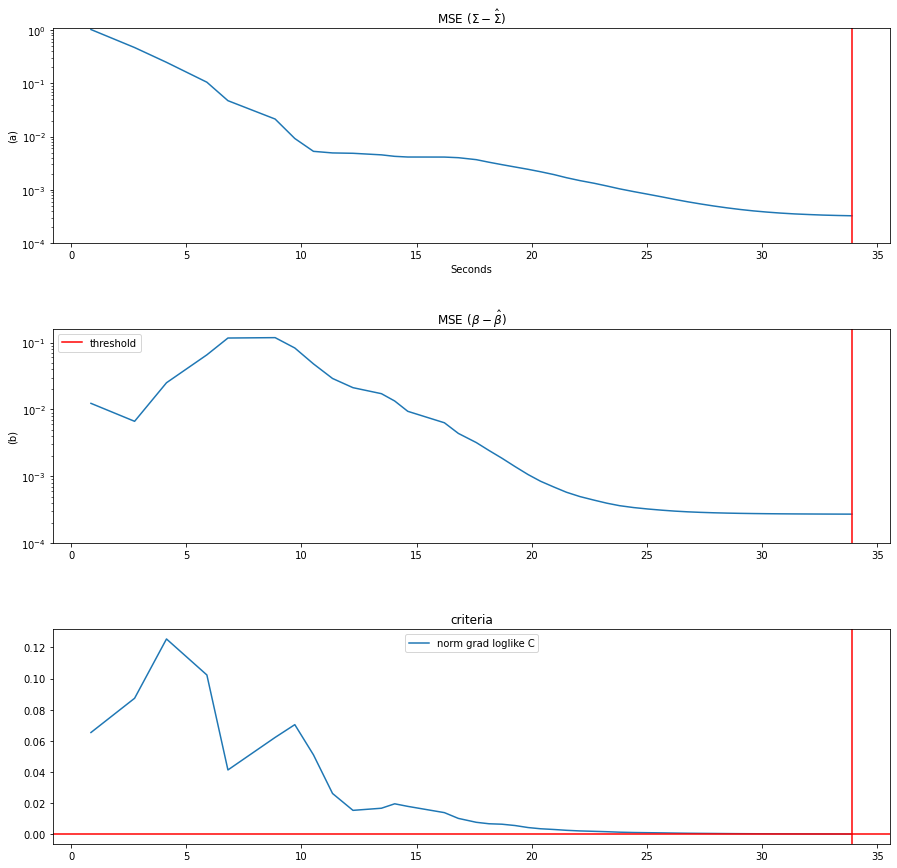

In [37]:
show(model,'',threshold = 1/(2*p**(13/11)))

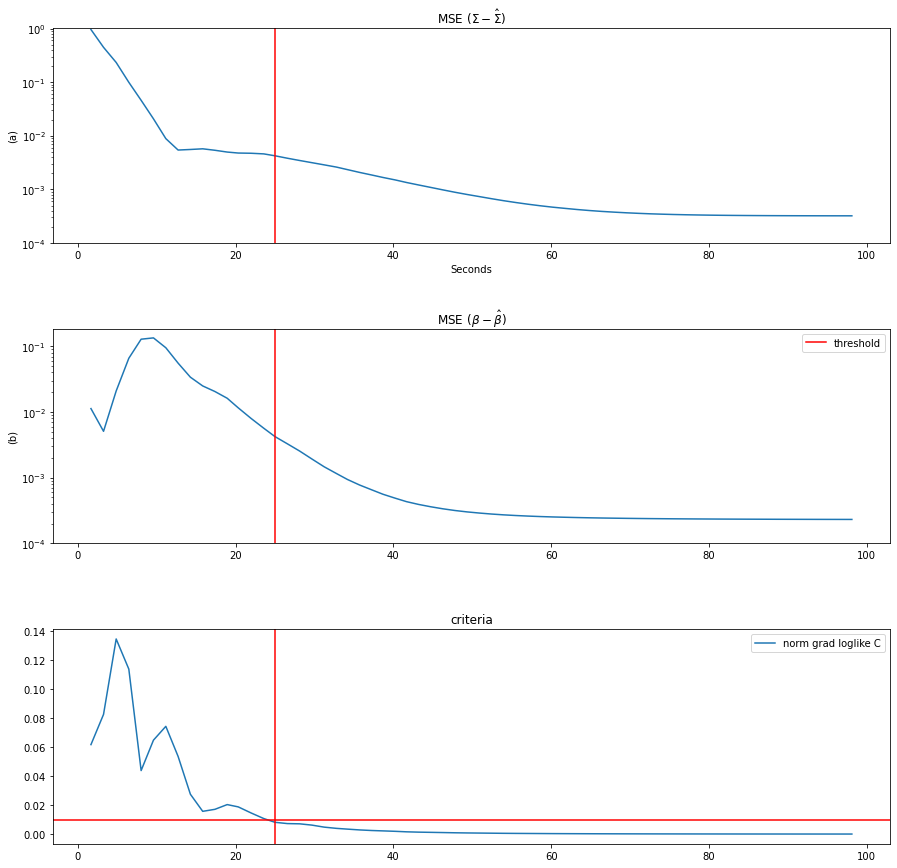

 p :  2000
time took  98.09395551681519


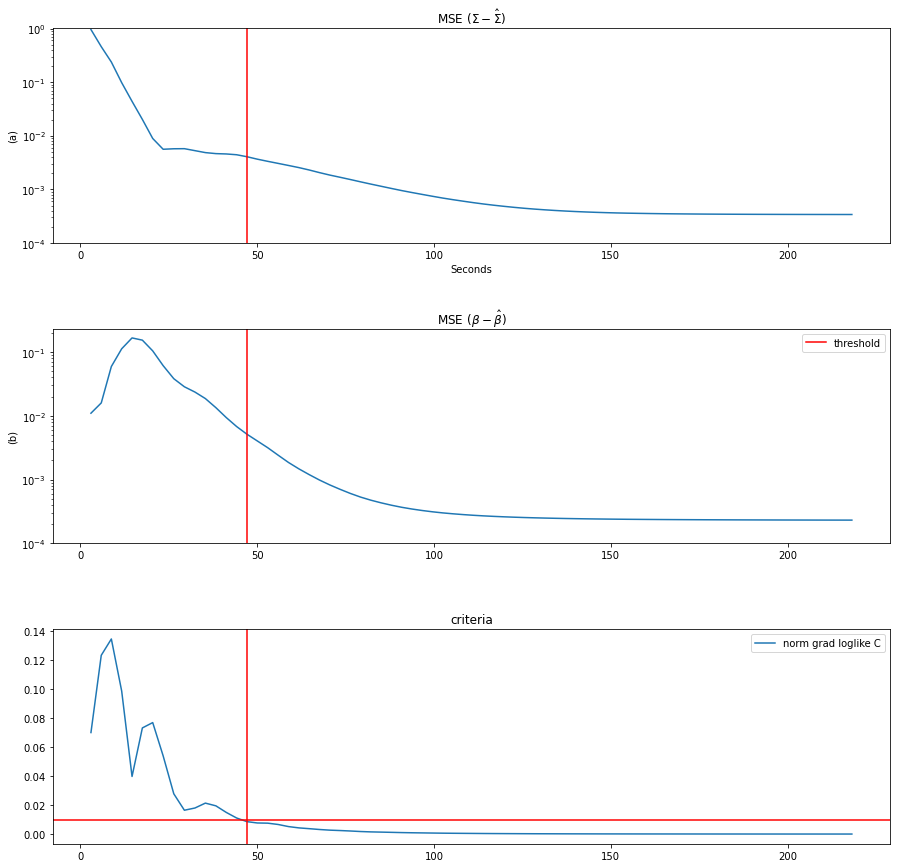

 p :  3000
time took  218.18006682395935


In [7]:
ps = [2000,3000]#[100,200,300,500,800,1000,1300,1500]
times = list()
models = list()
for p_ in ps: 
    p = p_
    #torch.manual_seed(0)
    Sigma_sampling = 1*torch.from_numpy(build_block_Sigma(p,q))/3 #+ 0.5*torch.eye(p)
    #true_C = torch.from_numpy(C_from_Sigma(Sigma_sampling, q))
    #true_Sigma_sampling = true_C@(true_C.T)
    true_beta =torch.randn((d, p))*0.8
    covariates = torch.randn((n,d))/1
    O =  0+torch.zeros((n,p))
    sample_model = sample_PLN()
    Y, Z  = sample_model.sample(Sigma_sampling,true_beta, O, covariates)
    Y = torch.from_numpy(Y)
    model = fastPLN()
    model.fit(Y,O,covariates, 120, verbose = False, tolerance = 1/(4*p**(13/11)))
    show(model, '')
    times.append(model.running_times[-1])
    models.append(model)
    print(' p : ', p)
    print('time took ', times[-1])
    

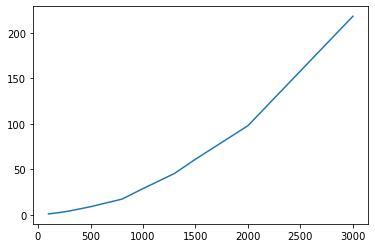

In [8]:
ps = [100,200,300,500,800,1000,1300,1500,2000,3000]#
times = [1.11,2.55,4.35,9.03,17.37,28.907,45.56,61.2,98,218.18]
plt.plot(ps,times)